In [1]:
import os
from pathlib import Path
import numpy as np
import torch
import esm
from esm.data import ESMStructuralSplitDataset
import matplotlib.pyplot as plt

In [2]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

In [10]:
model.load_state_dict(torch.load('model_weights_1024_BCE.pth'))
model.eval()

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [3]:
model = torch.load('trained_model_1024_BCE_6ep.pth')
model.eval()

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [4]:
train_dataset = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='train', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

valid_dataset = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='valid', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

In [5]:
batch_converter = alphabet.get_batch_converter()
contact_threshold = 15

Data point 2121, NQVEQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVVTGGEVKKLKRLTFQFGDARKDSSLHITAAQPGDTGLYLCAGADRGSTLGRLYFGRGTQLTVWPD


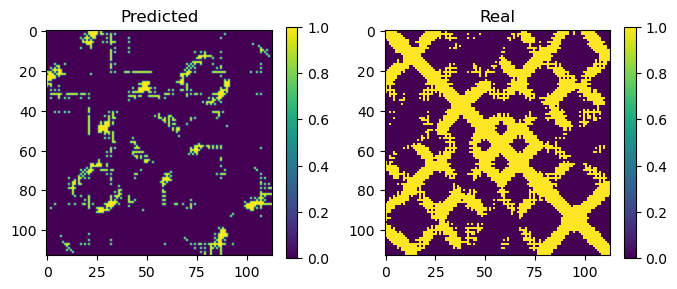

In [25]:
rand_example = np.random.randint(len(valid_dataset))
rand_target = valid_dataset[rand_example]

# rand_example = np.random.randint(len(train_dataset))
# rand_target = train_dataset[rand_example]

print(f"Data point {rand_example}, {rand_target['seq']}")

batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target_c)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [ ]:
# Load the PDB files for each example and calculate distances as the targets

def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 15.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))
    
    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

In [ ]:
# precision and prediction evaluation

def compute_precisions(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(outputs, np.ndarray):
        outputs = torch.from_numpy(outputs)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if outputs.dim() == 2:
        outputs = outputs.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if outputs.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {outputs.size()}, "
            f"targets of size {targets.size()}"
        )
    device = outputs.device

    batch_size, seqlen, _ = outputs.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    
    # Check what the batch size is, comes from "batch_size, seqlen, _ = outputs.size()"
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long) 

    # check the masked_fill function in repo
    outputs = outputs.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = outputs[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(outputs).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

In [26]:
# Load the example fastas to compare with repo results

from Bio import SeqIO
import os

def load_fasta_files(folder_path):
    
    fasta_files = [file for file in os.listdir(folder_path) if file.endswith(".fasta")]
    all_fasta_data = {}

    for fasta_file in fasta_files:
        file_path = os.path.join(folder_path, fasta_file)
        with open(file_path, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                all_fasta_data[record.id] = str(record.seq)

    return all_fasta_data

folder_path = r"C:\Users\neil_\Documents\GitHub\contact-prediction\data\Original"
fasta_data_dict = load_fasta_files(folder_path)

fasta_data_dict 

{'1A3A_1|Chains': 'MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK',
 '1XCR_1|Chains': 'GSACAEFSFHVPSLEELAGVMQKGLKDNFADVQVSVVDCPDLTKEPFTFPVKGICGKTRIAEVGGVPYLLPLVNQKKVYDLNKIAKEIKLPGAFILGAGAGPFQTLGFNSEFMPVIQTESEHKPPVNGSYFAHVNPADGGCLLEKYSEKCHDFQCALLANLFASEGQPGKVIEVKAKRRTGPLNFVTCMRETLEKHYGNKPIGMGGTFIIQKGKVKSHIMPAEFSSCPLNSDEEVNKWLHFYEMKAPLVCLPVFVSRDPGFDLRLEHTHFFSRHGEGGHYHYDTTPDIVEYLGYFLPAEFLYRIDQPKETHSIGRD',
 '5AHW_1|Chains': 'MSAYQTVVVGTDGSDSSLRAVDRAGQIAAASNAKLIIATAYFPQSEDSRAADVLKDEGYKMAGNAPIYAILREANDRAKAAGATDIEERPVVGAPVDALVELADEVKADLLVVGNVGLSTIAGRLLGSVPANVARRSKTDVLIVHTS'}

In [27]:
fasta_data_dict["1A3A_1|Chains"]

'MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK'

In [28]:
sequences_list = [sequence for sequence in fasta_data_dict.values()]

In [29]:
sequences_list[0]

'MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK'

In [30]:
indexed_sequences = list(enumerate(sequences_list))

In [31]:
indexed_sequences

[(0,
  'MANLFKLGAENIFLGRKAATKEEAIRFAGEQLVKGGYVEPEYVQAMLDREKLTPTYLGESIAVPHGTVEAKDRVLKTGVVFCQYPEGVRFGEEEDDIARLVIGIAARNNEHIQVITSLTNALDDESVIERLAHTTSVDEVLELLAGRK'),
 (1,
  'GSACAEFSFHVPSLEELAGVMQKGLKDNFADVQVSVVDCPDLTKEPFTFPVKGICGKTRIAEVGGVPYLLPLVNQKKVYDLNKIAKEIKLPGAFILGAGAGPFQTLGFNSEFMPVIQTESEHKPPVNGSYFAHVNPADGGCLLEKYSEKCHDFQCALLANLFASEGQPGKVIEVKAKRRTGPLNFVTCMRETLEKHYGNKPIGMGGTFIIQKGKVKSHIMPAEFSSCPLNSDEEVNKWLHFYEMKAPLVCLPVFVSRDPGFDLRLEHTHFFSRHGEGGHYHYDTTPDIVEYLGYFLPAEFLYRIDQPKETHSIGRD'),
 (2,
  'MSAYQTVVVGTDGSDSSLRAVDRAGQIAAASNAKLIIATAYFPQSEDSRAADVLKDEGYKMAGNAPIYAILREANDRAKAAGATDIEERPVVGAPVDALVELADEVKADLLVVGNVGLSTIAGRLLGSVPANVARRSKTDVLIVHTS')]

Data point 2, MSAYQTVVVGTDGSDSSLRAVDRAGQIAAASNAKLIIATAYFPQSEDSRAADVLKDEGYKMAGNAPIYAILREANDRAKAAGATDIEERPVVGAPVDALVELADEVKADLLVVGNVGLSTIAGRLLGSVPANVARRSKTDVLIVHTS


Text(0.5, 1.0, 'Prediction')

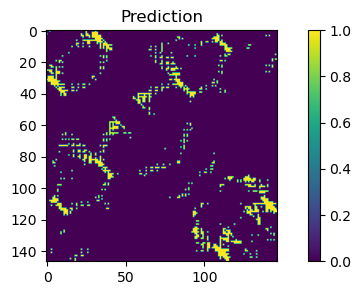

In [47]:
rand_example = np.random.randint(len(indexed_sequences))
rand_target = indexed_sequences[rand_example][1]

print(f"Data point {rand_example}, {rand_target}")

batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target)])

outputs = model(batch_tokens, return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(figsize=(8, 3))
im = ax.imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax.set_title("Prediction")

In [ ]:
# Create benchmark details on contacts ROC AUC accuracy loss, P@L

outputs_met = torch.tensor(np.array(outputs_conts[0]))
targets_met = torch.tensor(np.array(rand_target["dist"]))

example_metrics = evaluate_prediction(outputs_met, targets_met)

print(f"Metrics for: {rand_example}, {rand_target}")
for key, value in example_metrics.items():
    print(f"{key}: {value}")  
del outputs_met, targets_met

In [ ]:
# This is where the data is actually read in

PDB_IDS = ["1a3a", "5ahw", "1xcr"]

structures = {
    name.lower(): get_structure(PDBxFile.read(rcsb.fetch(name, "cif")))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain="A")
    for name, structure in structures.items()
}

# Downloaded fasta files directly from the PDB and saved in "data/" folder
sequences = {
    name: read_sequence(f"data/{name.lower()}.fasta")
    for name in PDB_IDS
}